# IN-STK5000/9000 - Medical Project

## Part 1 - Historical Data

Discovering structure in the data. It is uncertain if the symptoms present are all due to
the same disease, or if they are different conditions with similar symptoms. (a) looking at the
data (including symptoms), estimate whether a single-cause model is more likely than a multiplecause model. You can use anything, ranging from histograms or simple clustering algorithms
to a hierarchical Bayesian model.   

***  



### From data readme  

This is historical data in three tables.

X: observations about each patient
A: treatment
Y: outcome of treatment

The data is organised in the following files:

historical.dat: all the tables in one file (matlab format)
historical_X.dat: the X data
historical_A.dat: the A data
historical_Y.dat: the Y data

Modelling the X data can be done through both unsupervised and supervised models. As some of the genome features might be irrelevant, it is probably a good idea to try and filter them out somehow. In later parts of the project, you will be able to perform experiments to narrow done the important genes. For the latter approach, you can combine the last two columns into a classification label, which should give you a cross-validation score of between 60-70%.



## Note  
referring to the assignment text:  
```
• x129:130 ∈ {0, 1}^2, symptoms. These can be taken to be akin to labels in supervised learning.
There may be missing data here too, but for now we can assume they are included.
```

There are two ways to interpret this:  
1: the dataset has missing columns which are cruicial to our decision making  
2: some of the attributes of our already existing data are incorrect becuase lack of 
Despite this assumption, confounder variables are likely to exist, e.g. lifestyle.  

The relationships can be represented as a graphical model. 
We assume there to be some confounder variables


$Z \rightarrow X_{\setminus S} \rightarrow S \rightarrow (a \rightarrow y) \leftarrow \pi$    
$Z \rightarrow S$

Z - confounder variable(s)  
X - attributes in dataset  
S - symptoms  
a - action  
y - outcome  
$\pi$ - policy  

spurious association

### Assumptions  
every person has some disease

say something about confounder variable

Look at clusters, see how they separate features, symptoms  

Biplot on symptoms, look at eigenvalues for components  

https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot

np.cumsum(pca_model.explained_variance_ratio_)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, KernelPCA

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score   
import seaborn as sns

import matplotlib.cm as cm

###

from sklearn.datasets import make_biclusters
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score


In [2]:
# for reproducibility
SEED = 1337
np.random.seed(SEED)

Let's take a look at the dataset

In [3]:
feature_path = "../../data/medical/historical_X.dat"

X = pd.read_csv(feature_path, delimiter=" ", names=["sex", "smoker"] \
                                           + [f"gen_{i}" for i in range(1, 127)] \
                                           + ["symptom_1","symptom_2"])
X

,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
0,0,0,0,0,1,1,0,0,1,1,...,0,1,1,0,1,1,0,0,1,0
1,0,1,0,1,0,1,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
2,0,0,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,1,0,0
3,1,1,1,0,0,0,1,1,0,0,...,1,0,1,1,0,0,1,1,0,0
4,0,1,0,1,0,1,1,1,1,1,...,0,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,1,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,1,0
9996,1,0,1,1,1,0,1,1,0,0,...,1,0,1,1,0,0,1,0,0,0
9997,0,0,1,0,1,0,0,1,0,1,...,1,1,1,0,1,1,1,0,0,0
9998,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0


The task is to investigate whether there is a single disease or multiple diseases, and our best cues lie in the symptoms. How do the other attributes relate to these symptoms? To find out, we look at the correlation matrix. Pandas built in function uses Pearson correlation coefficient. This works well on 

In [4]:
X_corr = X.corr()
X_corr


,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
sex,1.000000,0.109603,0.007766,0.014346,-0.009029,0.005035,-0.010778,0.002589,-0.004750,-0.003941,...,0.012595,0.001446,0.002208,-0.000617,-0.023393,-0.014812,-0.001430,-0.014648,0.014270,0.012175
smoker,0.109603,1.000000,0.050425,-0.007127,0.030977,-0.021665,0.025645,0.036442,-0.019263,0.006718,...,0.021938,-0.025307,-0.007724,0.006012,0.014049,0.010707,0.020846,-0.012551,-0.023566,0.145667
gen_1,0.007766,0.050425,1.000000,-0.046432,0.386332,-0.395919,0.084694,0.566400,-0.374882,-0.116801,...,0.330004,-0.371892,0.010433,0.219953,0.135637,-0.039847,0.476740,-0.139736,-0.226389,0.113284
gen_2,0.014346,-0.007127,-0.046432,1.000000,-0.141214,0.105647,0.056152,-0.145896,-0.230952,-0.275728,...,-0.047439,-0.293198,-0.453831,-0.189144,-0.204592,0.287582,-0.058403,0.213693,0.448432,0.077794
gen_3,-0.009029,0.030977,0.386332,-0.141214,1.000000,-0.165907,0.007472,0.273980,-0.184872,0.250451,...,0.492008,-0.033860,0.224838,-0.240869,0.198433,0.124570,0.201123,-0.236210,-0.138678,0.236765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gen_124,-0.014812,0.010707,-0.039847,0.287582,0.124570,0.057048,-0.068374,-0.297818,-0.024739,-0.029531,...,-0.177008,-0.180164,-0.171791,-0.366230,0.035009,1.000000,-0.361859,0.030987,0.136688,0.062525
gen_125,-0.001430,0.020846,0.476740,-0.058403,0.201123,-0.478340,0.178688,0.473991,-0.349298,-0.249663,...,0.410805,-0.198281,0.036030,0.257561,0.180434,-0.361859,1.000000,-0.124496,-0.268632,0.071965
gen_126,-0.014648,-0.012551,-0.139736,0.213693,-0.236210,0.215471,0.048148,-0.087031,0.033066,-0.021576,...,-0.108583,-0.007114,-0.140690,-0.033081,-0.090537,0.030987,-0.124496,1.000000,0.191198,-0.052944
symptom_1,0.014270,-0.023566,-0.226389,0.448432,-0.138678,0.558176,0.115776,-0.108642,0.044841,0.129694,...,-0.081114,0.013884,-0.232290,-0.174283,-0.125147,0.136688,-0.268632,0.191198,1.000000,-0.017210


In [5]:
from scipy.spatial.distance import jaccard
X_corr = X.corr(method=lambda v, u: 1 - jaccard(v, u))
X_corr


,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
sex,1.000000,0.262565,0.340029,0.344594,0.332142,0.333646,0.327568,0.335952,0.328073,0.327799,...,0.339973,0.331235,0.334356,0.334973,0.323148,0.328303,0.335589,0.360898,0.322988,0.092302
smoker,0.262565,1.000000,0.236687,0.212690,0.228070,0.203707,0.224311,0.229938,0.204194,0.215014,...,0.223488,0.201823,0.210427,0.217023,0.219744,0.218863,0.223744,0.222222,0.196382,0.141137
gen_1,0.340029,0.236687,1.000000,0.319943,0.534234,0.177856,0.372928,0.645867,0.183879,0.281395,...,0.500596,0.185370,0.339915,0.442299,0.398385,0.319324,0.588809,0.312228,0.224162,0.122882
gen_2,0.344594,0.212690,0.319943,1.000000,0.280035,0.383460,0.361213,0.276733,0.238402,0.220811,...,0.317210,0.215456,0.162075,0.260020,0.252080,0.479087,0.314460,0.469134,0.555983,0.111966
gen_3,0.332142,0.228070,0.534234,0.280035,1.000000,0.262958,0.337118,0.469918,0.254154,0.452621,...,0.596697,0.317131,0.442703,0.237838,0.429222,0.393935,0.433154,0.274900,0.258560,0.162580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gen_124,0.328303,0.218863,0.319324,0.479087,0.393935,0.357454,0.302793,0.214692,0.319432,0.316698,...,0.260307,0.255112,0.261346,0.190544,0.349380,1.000000,0.193151,0.380721,0.381000,0.107374
gen_125,0.335589,0.223744,0.588809,0.314460,0.433154,0.149563,0.418272,0.585762,0.192556,0.228519,...,0.546909,0.249405,0.351104,0.461639,0.420204,0.193151,1.000000,0.317800,0.207719,0.110230
gen_126,0.360898,0.222222,0.312228,0.469134,0.274900,0.462094,0.385250,0.331074,0.376045,0.351810,...,0.321857,0.359192,0.307945,0.353833,0.328031,0.380721,0.317800,1.000000,0.432704,0.077365
symptom_1,0.322988,0.196382,0.224162,0.555983,0.258560,0.624087,0.368662,0.269697,0.333054,0.373143,...,0.280867,0.319187,0.218754,0.243330,0.261589,0.381000,0.207719,0.432704,1.000000,0.082043


In [ ]:
threshold = 0.4
cond = (X_corr["symptom_1"] > threshold) \
        | (X_corr["symptom_1"] < -threshold) \
        | (X_corr["symptom_2"] > threshold) \
        | (X_corr["symptom_2"] < -threshold) 
        
most_corr = X_corr.loc[cond][["symptom_1", "symptom_2"]][:-2]
fig, ax = plt.subplots(figsize=(9,6))
ax.set_title("Most correlated feauters with symptoms")
sns.heatmap(most_corr, annot=True)

In [7]:
def cosine_similarity(x1, x2):
    return (x1 @ x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
X_corr = X.corr(method=cosine_similarity)
X_corr


,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
sex,1.000000,0.435488,0.507500,0.512578,0.498661,0.500365,0.493492,0.502940,0.494083,0.493780,...,0.507433,0.497656,0.501152,0.501842,0.488455,0.494319,0.502537,0.531722,0.488684,0.229065
smoker,0.435488,1.000000,0.401293,0.368147,0.389280,0.353626,0.383077,0.391525,0.354049,0.369339,...,0.382436,0.350721,0.363735,0.373565,0.376960,0.376064,0.383270,0.389730,0.339836,0.280812
gen_1,0.507500,0.401293,1.000000,0.484786,0.696418,0.302020,0.543284,0.784841,0.310671,0.439255,...,0.667205,0.312791,0.507381,0.613328,0.569793,0.484076,0.741195,0.476936,0.366607,0.297508
gen_2,0.512578,0.368147,0.484786,1.000000,0.437548,0.554413,0.530768,0.433514,0.385077,0.361813,...,0.481657,0.354578,0.278957,0.412733,0.402681,0.647833,0.478467,0.639928,0.715498,0.274418
gen_3,0.498661,0.389280,0.696418,0.437548,1.000000,0.416440,0.504264,0.639383,0.405336,0.623246,...,0.747420,0.481586,0.613725,0.384280,0.600648,0.565215,0.604476,0.432241,0.411288,0.379923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gen_124,0.494319,0.376064,0.484076,0.647833,0.565215,0.526670,0.464844,0.353492,0.484222,0.481082,...,0.413085,0.406536,0.414395,0.320096,0.517840,1.000000,0.323768,0.552859,0.552250,0.262912
gen_125,0.502537,0.383270,0.741195,0.478467,0.604476,0.260223,0.589855,0.738780,0.322960,0.372065,...,0.707105,0.399270,0.519740,0.631674,0.591763,0.323768,1.000000,0.483422,0.344328,0.269773
gen_126,0.531722,0.389730,0.476936,0.639928,0.432241,0.634043,0.557837,0.498700,0.548360,0.522277,...,0.488232,0.530240,0.472172,0.523986,0.495355,0.552859,0.483422,1.000000,0.607844,0.204496
symptom_1,0.488684,0.339836,0.366607,0.715498,0.411288,0.768978,0.539066,0.425186,0.499926,0.543726,...,0.438917,0.484162,0.359242,0.391769,0.415004,0.552250,0.344328,0.607844,1.000000,0.200003


Let's look at the most correlated features with respect to the symptoms

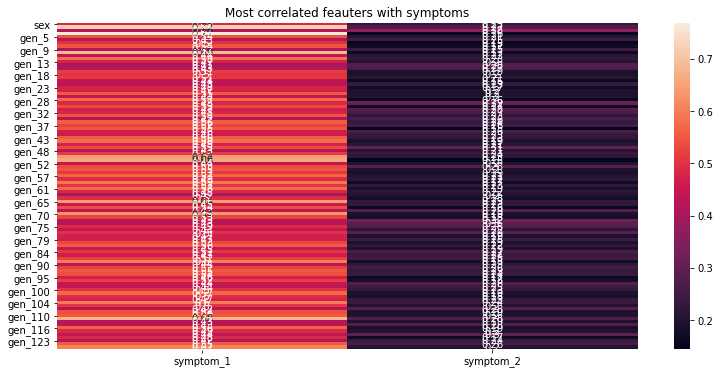

In [8]:
threshold = 0.4
cond = (X_corr["symptom_1"] > threshold) \
        | (X_corr["symptom_1"] < -threshold) \
        | (X_corr["symptom_2"] > threshold) \
        | (X_corr["symptom_2"] < -threshold) 
        
most_corr = X_corr.loc[cond][["symptom_1", "symptom_2"]][:-2]
fig, ax = plt.subplots(figsize=(13, 6))
ax.set_title("Most correlated feauters with symptoms")
sns.heatmap(most_corr, annot=True)

The first symptom seems likely to be caused, or at the very least affected by by genetical factors more than anything, both positively and negatively. The second symptom did not give us any highly correlated features, which might indicate that a. there is a nonlinear decision boundary between the features and the symptoms, or b. that there are confounder variables affecting this symptom, or c. that the symptom is random/unaffected.

In [9]:
columns = list(X.columns)
X.corr()[["symptom_1", "symptom_2"]][:2]

,symptom_1,symptom_2
sex,0.014270,0.012175
smoker,-0.023566,0.145667


In [11]:
np.cumsum(reductor.explained_variance_ratio_)

array([0.12727864, 0.23215345])

You would need 70 components for 90% of the variance, but for vizualization we selected 2 components which amounts for 32% of the variance.

0.32643006110799566

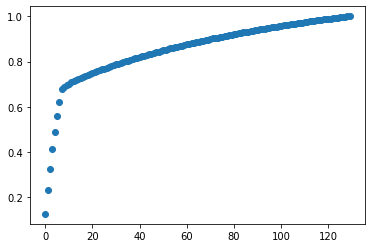

In [19]:
pca_model = PCA(n_components=X.shape[1], random_state=SEED)
pca_model.fit(X)

plt.figure()
plt.plot(np.cumsum(pca_model.explained_variance_ratio_), "o")
np.cumsum(pca_model.explained_variance_ratio_)[2]

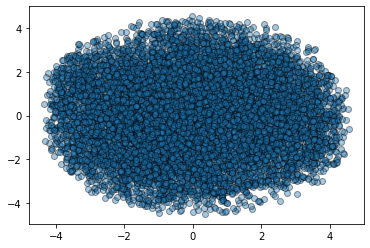

In [10]:
reductor = PCA(n_components=2)
x1, x2 = xT = reductor.fit_transform(X).T
plt.scatter(x1, x2, edgecolor="k", alpha=0.4)

In [13]:
s1, = X[["symptom_1"]].to_numpy().T
s2, = X[["symptom_2"]].to_numpy().T
X_symptoms = s1 + s2
a, b, c = [(X_symptoms == i).sum() for i in range(3)]
print("Individuals with 0 symptoms:", a, "\nIndividuals with 1 symptom:", b, "\nIndividuals with both symptoms:", c)
print("Individuals with symptom 1", s1.sum(), "\nIndividuals with symptom 2:", s2.sum())

Individuals with 0 symptoms: 4832 
Individuals with 1 symptom: 4744 
Individuals with both symptoms: 424
Individuals with symptom 1 4619 
Individuals with symptom 2: 973


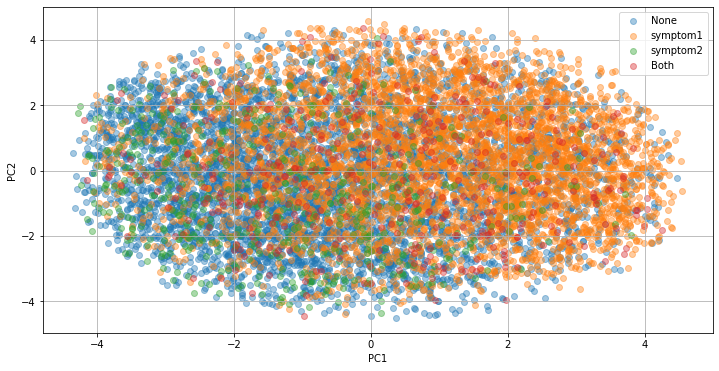

In [20]:
plt.subplots(figsize=(12, 6))
conds = [(s1 == j) & (s2 == i) for i in range(2) for j in range(2)]
for cond, label in zip(conds, ["None", "symptom1", "symptom2", "Both"]):
    plt.scatter(x1[cond], x2[cond], label=label, alpha=0.4)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
plt.legend()
plt.grid()

The separation between the symptoms and lack of symptoms gives us an indication that this is a multiple cause model, as it seems that the data is fairly separated on the people with symptom 1 and people with no symptoms. Despite our limited visualization, 

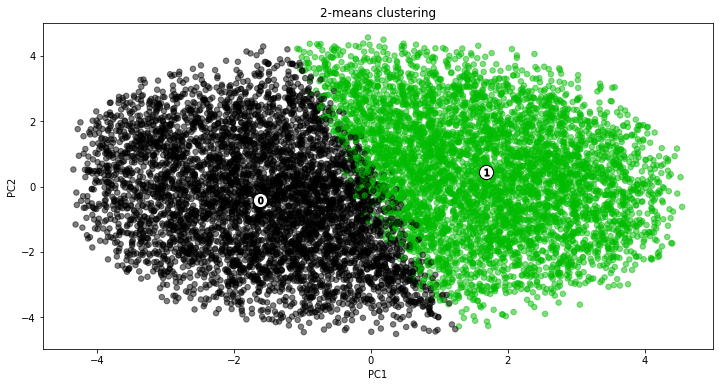

In [22]:
def kmeans_cluster_data(X, k=2, plot=True, fig=None, ax=None):
    """Takes in a dataset and clusters it for the n dimensions of the dataset.
    If plot is enabled, the dataset is then reduced using pca before being plotted in a 2 dimensional space
    Dimensions are kept for the clusterer
    
    returns labels"""
    clusterer = KMeans(n_clusters=k, random_state=SEED)
    labels = clusterer.fit_predict(X)
    
    if plot:
        if not (fig or ax):
            fig = plt.figure(figsize=(12, 6))
            ax = fig.add_subplot()
            
        elif fig:
            ax = fig.add_subplot()
            
        colors = cm.nipy_spectral(labels.astype(float) / k)
            
        ax.set_title(f"{k}-means clustering")
        pca = PCA(n_components=2)
        
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        
        xp = pca.fit_transform(X)
        centroids = pca.transform(clusterer.cluster_centers_)
        ax.scatter(*xp.T, s=30, c=colors, alpha=0.5)
        ax.scatter(*centroids.T, marker='o', c="white", alpha=1, s=200, edgecolor='k')
        for i, c in enumerate(centroids):
            ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
            
    return labels, clusterer

k2labels, _ = kmeans_cluster_data(X.to_numpy()[:-2], k=2)

The resemblance is visible from a 2-cluster model. The clusters are almost linear even when reduced with pca, as they are linear in the $\mathbb{R}^{130}$ space. Can we see how well the clusters are separated in high dimensionlal space?

In [23]:
range_n_clusters = [2, 3, 4, 5, 6, 10, 15]

for n_clusters in range_n_clusters:
    cluster_labels, clusterer = kmeans_cluster_data(X, k=n_clusters, ax=ax2, plot=False)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.08818403388966967
For n_clusters = 3 The average silhouette_score is : 0.07341947744865071
For n_clusters = 4 The average silhouette_score is : 0.06737980071078926
For n_clusters = 5 The average silhouette_score is : 0.06450263107302907
For n_clusters = 6 The average silhouette_score is : 0.0630069487251371
For n_clusters = 10 The average silhouette_score is : 0.06216781119465504
For n_clusters = 15 The average silhouette_score is : 0.06027738785960344


For the clustering part:
* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
* https://scikit-learn.org/stable/modules/biclustering.html

(b) Try and determine whether some particular factors are
important for disease epidemiology and may require further investigations.
You need to be able to validate your findings either through a holdout-set methodology,
appropriately used statistical tests, or Bayesian model comparison.

In [13]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

In [14]:
import numpy as np
import pandas as pd

X = pd.read_csv('../../data/medical/historical_X.dat', header=None, sep=" ")
A = pd.read_csv('../../data/medical/historical_A.dat', header=None, sep=" ")
Y = pd.read_csv('../../data/medical/historical_Y.dat', header=None, sep=" ")
X = X.rename(index=str, columns={0: 'gender', 1: 'smoker'})
X = X.rename(index=str, columns={i: 'gene'+str(i-1) for i in range(2,128)})
X_org = X.copy()
X.insert(0, 'symptoms', X[128] + X[129]*2)
X = X.drop(labels=[128, 129], axis=1)
A = A.rename(index=str, columns={0: 'action'})
Y = Y.rename(index=str, columns={0: 'outcome'})

We are assuming symptoms as our target variable. 

Using L1 regularization on Logistic regression for reducing dimensionality.

In [15]:
Xs = X.drop(labels=['symptoms'], axis=1)
ys = X['symptoms']
C = [10, 1, .5, .2, .1]
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear', multi_class='ovr')
    fit = clf.fit(Xs, ys)
    print((fit.coef_[:,:]>np.zeros(fit.coef_.shape[1])).sum(axis=1))

[60 78 62 52]
[57 71 53 42]
[56 60 36 29]
[51 32 16 10]
[41 16  3  5]


Let's check how the features for C=0.1 (41,16,3,5) performs.

In [16]:
(fit.coef_[:,:]>np.zeros(fit.coef_.shape[1])).sum(axis=0)

array([0, 2, 0, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0])

Most features appear significant in one class only, a few in two but none in more than 2. 

Using Random Forest for finding feature importance.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import sem

In [18]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(Xs, ys)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
deviations = sem([tree.feature_importances_ for tree in clf.estimators_], axis=0)
sorted_feature_ixs = np.argsort(clf.feature_importances_)[::-1]

Let's visualize the feature importance for all features.

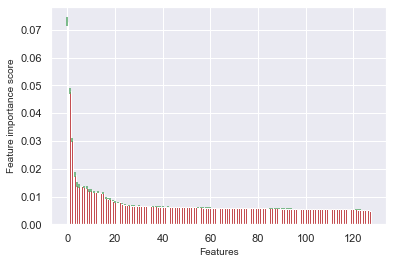

In [20]:
plt.bar(range(Xs.shape[1]), clf.feature_importances_[sorted_feature_ixs],
       color="r", yerr=deviations[sorted_feature_ixs], ecolor='g')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Feature importance score', fontsize=10)
plt.show()

We can see that only few features are more important. Let's zoom in with only first 10 of the important ones.

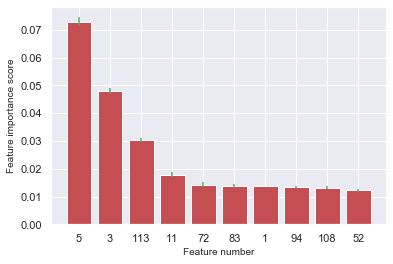

In [21]:
plt.bar(range(10), (clf.feature_importances_[sorted_feature_ixs])[:10],
       color="r", yerr=(deviations[sorted_feature_ixs])[:10], ecolor='g')
plt.xticks(range(10), sorted_feature_ixs[:10])
plt.xlabel('Feature number', fontsize=10)
plt.ylabel('Feature importance score', fontsize=10)
plt.show()

Looking at the above graph, we can select the first four (i.e., 5,3,113,11) features which are clearly more relevant than others. 

In [22]:
X_imp = X.iloc[:,sorted_feature_ixs[:4]].copy()

Let's do clustering with only these important features.


In [23]:
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import sokalmichener

In [26]:
X_new = pd.concat([X_imp, X_org.iloc[:,-2:]], axis=1)

In [ ]:
distances = pairwise_distances(X_new, metric=sokalmichener)

In [ ]:
n_cluster = np.arange(1,9)
scores = np.zeros(len(n_cluster))
clusters = np.zeros([len(X_new), len(n_cluster)], dtype=np.int)
for i, n in enumerate(n_cluster):
    clusterer = AgglomerativeClustering(n_clusters=n, affinity='precomputed', 
                                        linkage="average")
    clusters[:,i] = clusterer.fit_predict(distances)
for i in range(1, len(n_cluster)):
    scores[i] = silhouette_score(distances, clusters[:,i], metric='precomputed')
plt.bar(n_cluster[1:], scores[1:])

### Shap values

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(clf)

In [ ]:
expected_value = explainer.expected_value[0]
shap_values = explainer.shap_values(Xs)[0]

In [ ]:
shap.summary_plot(shap_values, Xs)

* Shap values  

* Meaning of epidemiology? Do we predict disease or symptoms? Using which variables?

Measuring the effect of actions. We also observe the effects of two different therapeutic
interventions, one of which is placebo, and the other is an experimental drug. Try and measure
the effectiveness of the placebo versus the active treatment. Are there perhaps cases where the
active treatment is never effective, or should it always be recommended?
1

* Synthetic control 

## Part 2 - Improved Policy

## Part 3 - Adaptive experiment design